In [347]:
%matplotlib inline
import os
import sys
import imp
import numpy as np
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

import matplotlib
import matplotlib.pyplot as plt
import IPython.html.widgets as weejet

# get spectral band information for clirad and rrtmg
import rtmtools.clirad.sw.info as cliradswinfo
import rtmtools.clirad.lw.info as cliradlwinfo
import rtmtools.rrtmg.sw.info as rrtmgswinfo
import rtmtools.rrtmg.lw.info as rrtmglwinfo

from IPython.display import HTML

matplotlib.rcParams.update({'xtick.direction': 'out',
                            'xtick.major.size': 7, 'xtick.major.width': 1,
                            'xtick.minor.size': 4, 'xtick.minor.width': 1,
                           'ytick.direction': 'out'})

In [36]:
def get_fpath():
    return '/nuwa_cluster/home/jackyu/climate_models/scam/examples/ARM95/\
cam5_noavg_LW_rrtmgMcICA_rrtmgMcICAaer_SW_rrtmgMcICA_rrtmgMcICAaer/aer_opts.dat'




In [286]:
def get_clirad_midband_wavenumbers():
    wavenumbers = [.5 * sum(limit) \
                   for iband, limits in cliradswinfo.wavenumber_bands().items() \
                   for limit in limits]
    return sorted(wavenumbers)

    
def get_rrtmg_midband_wavenumbers():
    return [.5 * sum(limits[0]) for iband, limits in rrtmgswinfo.wavenumber_bands().items()]


def preprocess_data():
    df = pd.read_csv(get_fpath(), sep = r'\s+', index_col = [0, 1, 2, 3])
    df.index = df.index.droplevel(1)
    df = df.unstack(1)
    df.index.set_levels(get_rrtmg_midband_wavenumbers(), level=1, inplace = True)
    df.index.rename(['nstep', 'midband wavenubmer'], inplace = True)
    df.columns = df.columns.droplevel(0)
    return df


def quick_plt(df, nstep = 500, layers = None):
    ax = df.loc[(nstep, slice(None))].sort_index().loc[:, layers]\
    .plot(figsize = (10, 11), marker = 'x')
    
    ax.set_xscale('log')
    ax.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    
    ax.set_yscale('log')
    ax.set_ylabel(r'$\tau$', fontsize = 17.)
    ax.set_ylim((0, .02))
    
    ax.legend(loc = 'upper left')
    
    
    return




In [159]:
df = preprocess_data()

# Aerosol optical properties

RRTMG-SW 'extinction optical depth' for 31 atmospheric layers at some model timestep.

The wavenumbers are taken to be the in the middle of each spectral band.

<function __main__.<lambda>>

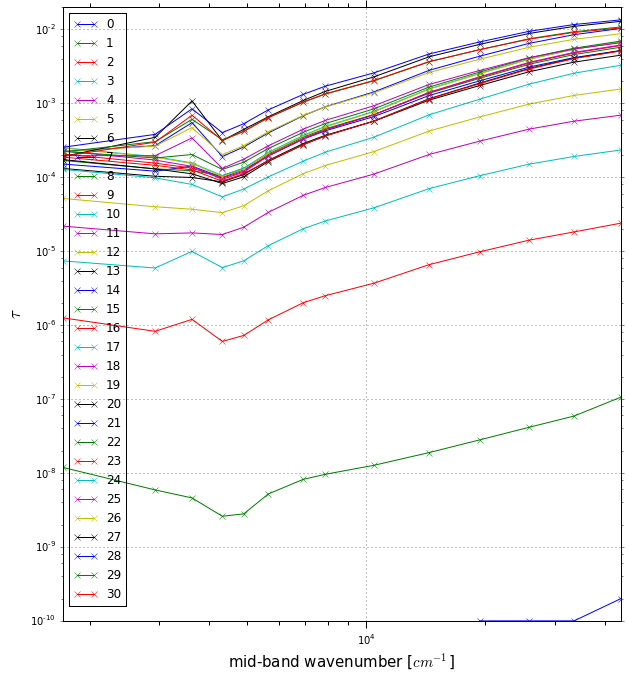

In [223]:
weejet.interact(lambda nstep: \
                quick_plt(df, nstep = nstep, layers = range(30 + 1)),
               nstep = (0, 1225, 1))

### RRTMG's extinction fitted onto CLIRAD

#### Fitted scipy's InterpolatedUnivariateSpline() using a univariate spline with order = 1.

In [324]:
def fit_extinction_onto_CLIRAD(sample):
    # fit the sample using InterpolatedUnivariateSpline
    order = 1
    f = InterpolatedUnivariateSpline(sample.index.values, sample.values, 
                                 k = order)

    # predict for CLIRAD-SW's wavenumbers, return in same format as sample
    x = get_clirad_midband_wavenumbers()
    prediction = pd.Series(f(x), index = x)
    return sample, prediction


def plt_extinction_sample_and_fit(nstep = 500, layer = 20):
    # get a sample of (wavenumber, extinction)
    sample = df.loc[(nstep, slice(None))].sort_index().loc[:, layer]
    sample, prediction = fit_extinction_onto_CLIRAD(sample)
    
    sample.name = 'RRTMG'
    prediction.name = 'CLIRAD'
    
    fig, axs = plt.subplots(nrows = 1, ncols = 1, 
                       figsize = (6, 6), )
    sample.plot(ax = axs, marker = 'x', linestyle = 'None', label = 'RRTMG')
    prediction.plot(ax = axs, marker = '.', label = 'CLIRAD')

    axs.set_yscale('log')
    axs.set_ylabel(r'$\tau$', fontsize = 15.)
    axs.set_ylim((1e-5, 1e-2))
    
    axs.set_xscale('log')
    axs.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    axs.set_xlim((0, 45000))
    
    axs.legend(loc = 'upper left')
    
    return fig, axs

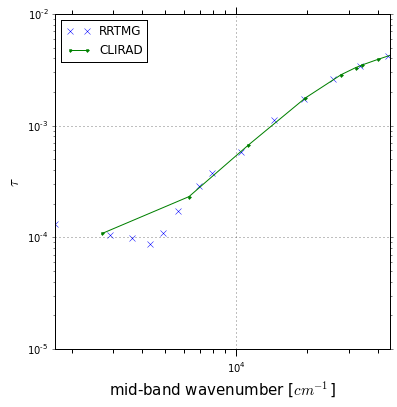

In [441]:
weejet.interact(plt_extinction_sample_and_fit,
               nstep = (0, 1225, 1), layer = (0, 30, 1))

#### Fitted using cubic spline subroutines from Numerical Recipes (3.3 Cubic Spline Interpolation)

In [449]:
with open('cubicsplint.f90', mode = 'r', encoding = 'utf-8') as file:
    content = file.read()

print(content)




SUBROUTINE spline(x,y,n,yp1,ypn,y2)
  implicit none
  INTEGER, intent(in) :: n
  REAL, intent(in) :: yp1,ypn,x(n),y(n)
  real, intent(out) :: y2(n)
  integer :: NMAX
  PARAMETER (NMAX=500)
  ! Given arrays x(1:n) and y(1:n) containing a tabulated function, i.e., yi = f(xi), with
  ! x1 < x2 < ... < xN , and given values yp1 and ypn for the first derivative of the interpolating
  ! function at points 1 and n, respectively, this routine returns an array y2(1:n) of
  ! length n which contains the second derivatives of the interpolating function at the tabulated
  ! points xi. If yp1 and/or ypn are equal to 1  1030 or larger, the routine is signaled to set
  ! the corresponding boundary condition for a natural spline, with zero second derivative on
  ! that boundary.
  ! Parameter: NMAX is the largest anticipated value of n.
  INTEGER i,k
  REAL p,qn,sig,un,u(NMAX)
  if (yp1.gt..99e30) then  ! The lower boundary condition is set either to be 
     y2(1) = 0.            ! "natural"
     

In [427]:
!ls *.f90 *.so

cubic.cpython-34m.so  cubicsplint.f90


In [448]:
!rm cubic.cpython-34m.so
del cubic

!f2py3 -c -m cubic cubicsplint.f90 > f2py3.log

import cubic
imp.reload(cubic)

<module 'cubic' from '/nuwa_cluster/home/jackyu/climate_models/scam/SCAM_radiation_notebooks/cubic.cpython-34m.so'>

In [446]:
def fit_extinction_onto_CLIRAD_f2py(sample):
    '''
    This fits using cubic spline subroutines from Numerical Recipes
    '''
    y2 = cubic2.spline(sample.index.values, sample.values, 2e30, 2e30)
    cubic_spline_fit = np.vectorize(lambda x: cubic2.splint(sample.index.values, sample.values, y2, x))
    values_clirad = cubic_spline_fit(get_clirad_midband_wavenumbers())
    prediction = pd.Series(values_clirad, index = get_clirad_midband_wavenumbers())
    return sample, prediction

def plt_extinction_sample_and_fit_f2py(nstep = 500, layer = 20):
    # get a sample of (wavenumber, extinction)
    sample = df.loc[(nstep, slice(None))].sort_index().loc[:, layer]
    sample, prediction = fit_extinction_onto_CLIRAD_f2py(sample)
    
    sample.name = 'RRTMG'
    prediction.name = 'CLIRAD'
    
    fig, axs = plt.subplots(nrows = 1, ncols = 1, 
                       figsize = (6, 6), )
    sample.plot(ax = axs, marker = 'x', linestyle = 'None', label = 'RRTMG')
    prediction.plot(ax = axs, marker = '.', label = 'CLIRAD')

    axs.set_yscale('log')
    axs.set_ylabel(r'$\tau$', fontsize = 15.)
    axs.set_ylim((1e-5, 1e-2))
    
    axs.set_xscale('log')
    axs.set_xlabel(r'mid-band wavenumber [$cm^{-1}$]', fontsize = 15.)
    axs.set_xlim((0, 45000))
    
    axs.legend(loc = 'upper left')
    
    return fig, axs


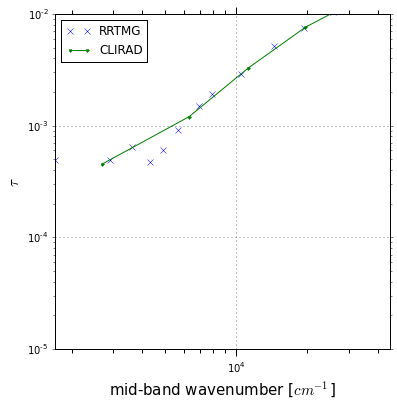

In [447]:
weejet.interact(plt_extinction_sample_and_fit_f2py,\
                nstep = (0, 1225, 1), layer = (0, 30, 1))

In [8]:
HTML('''
<script>
show_code = true;
function code_toggle() {
if (show_code) {$('div.input').hide();} else {$('div.input').show();}
show_code = !show_code
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>
''')